In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Using MacBook Mps

device = torch.device("mps") if torch.has_mps else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


/var/folders/y1/phf8gpf16r3cyywg9ch583jc0000gn/T/ipykernel_13752/3555965206.py:2: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps") if torch.has_mps else torch.device("cpu")


In [ ]:
#2. Pandas for data preapring
data = pd.read_excel("data_50k.xlsx")

In [22]:
# Podział na cechy (X) i etykiety (y)
X = data.drop(columns=['Y']).values  # Cechy wejściowe
y = data['Y'].values                 # Etykiety klasyfikacji: 0, 1


In [ ]:
# Data Seperation
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Balansing the data - SMOTE + Undersampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Train and validate set
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
# Creating Dataset
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)


In [ ]:
# 2. Model Architecture: LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Dodanie wymiaru czasowego (batch_size, seq_length=1, input_size)
        h, _ = self.lstm(x)  # Przekazanie przez LSTM
        h = h[:, -1, :]  # Wybór ostatniego kroku czasowego
        h = self.batch_norm(h)  # Batch Normalization
        h = self.dropout(h)  # Dropout
        out = self.fc(h)
        return out


In [ ]:
# Model Parameter
input_size = 37
hidden_size = 100
num_layers = 5  # Ograniczenie liczby warstw ze względu na pamięć
output_size = 2
dropout_rate = 0.3

In [29]:
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)


In [ ]:
# 3. FCost Function and opytymalizators
class_weights = torch.tensor([1.0, 1.5]).to(device)  # Wagi klas dla nierównomiernych danych
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# 4. Trening the model with Early Stopping
best_val_loss = float("inf")
patience = 10
epochs_without_improvement = 0

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # evaulating the model
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_lstm_model.pth")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break


Epoch [1/100], Loss: 0.7632, Val Loss: 0.6889
Epoch [2/100], Loss: 0.7134, Val Loss: 0.6880
Epoch [3/100], Loss: 0.6824, Val Loss: 0.6872
Epoch [4/100], Loss: 0.6654, Val Loss: 0.6863
Epoch [5/100], Loss: 0.6572, Val Loss: 0.6856
Epoch [6/100], Loss: 0.6560, Val Loss: 0.6848
Epoch [7/100], Loss: 0.6526, Val Loss: 0.6841
Epoch [8/100], Loss: 0.6462, Val Loss: 0.6834
Epoch [9/100], Loss: 0.6357, Val Loss: 0.6828
Epoch [10/100], Loss: 0.6272, Val Loss: 0.6822
Epoch [11/100], Loss: 0.6189, Val Loss: 0.6817
Epoch [12/100], Loss: 0.6140, Val Loss: 0.6813
Epoch [13/100], Loss: 0.6099, Val Loss: 0.6808
Epoch [14/100], Loss: 0.6070, Val Loss: 0.6804
Epoch [15/100], Loss: 0.6020, Val Loss: 0.6800
Epoch [16/100], Loss: 0.5990, Val Loss: 0.6797
Epoch [17/100], Loss: 0.5962, Val Loss: 0.6793
Epoch [18/100], Loss: 0.5943, Val Loss: 0.6790
Epoch [19/100], Loss: 0.5913, Val Loss: 0.6787
Epoch [20/100], Loss: 0.5893, Val Loss: 0.6784
Epoch [21/100], Loss: 0.5879, Val Loss: 0.6781
Epoch [22/100], Loss: 

In [ ]:
# 5. Model Evaulation
model.load_state_dict(torch.load("best_lstm_model.pth"))
model.eval()
with torch.no_grad():
    y_val_probs = torch.softmax(model(X_val_tensor), dim=1)[:, 1].cpu().numpy()
    y_val_preds = (y_val_probs > 0.5).astype(int)


In [ ]:
# Metrics
accuracy = accuracy_score(y_val, y_val_preds)
recall = recall_score(y_val, y_val_preds)
f1 = f1_score(y_val, y_val_preds)
conf_matrix = confusion_matrix(y_val, y_val_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.4966
Recall: 1.0000
F1 Score: 0.6637


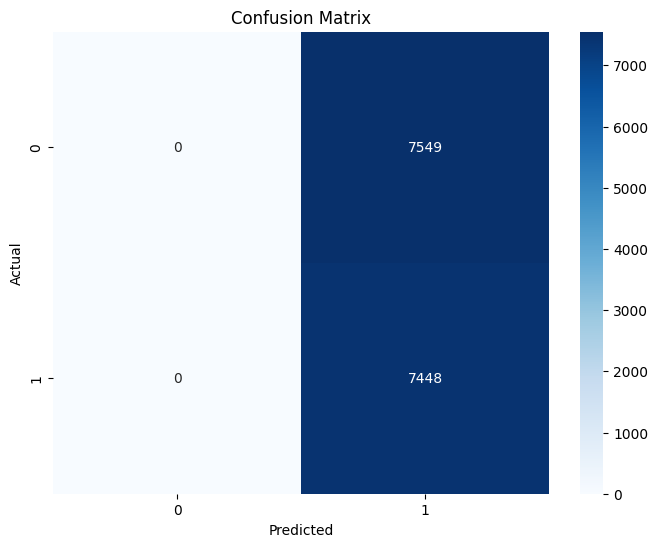

In [ ]:
# Confuzion matrix:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

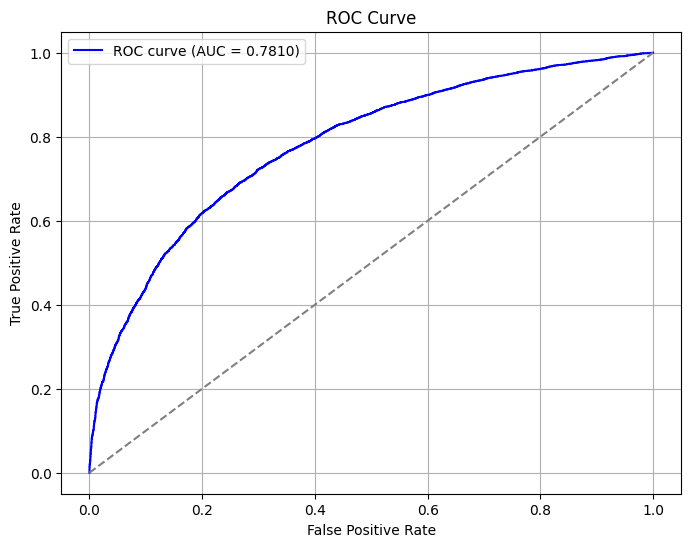

ROC AUC: 0.7810
Gini Coefficient: 0.5620


In [ ]:
# 6. ROC-AUC curve and  Gini coef
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
roc_auc = auc(fpr, tpr)
gini = 2 * roc_auc - 1

# Krzywa ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Gini Coefficient: {gini:.4f}")